# Segmentation of Indian Traffic

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [1]:
!pip install -U tensorflow==2.2.0 -q
!pip install -U keras==2.3.1 -q
!pip install -U segmentation-models -q

In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import pathlib
import datetime
import tensorflow as tf

%load_ext tensorboard

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
!gdown --id 1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ
To: /content/data.zip
100% 2.34G/2.34G [00:10<00:00, 230MB/s]


In [5]:
from zipfile import ZipFile
z = ZipFile('data.zip')
z.extractall()

In [6]:
# Indian Driving in Traffic - Download Video File
!gdown --id 1fl0eKn1PHpMv6mOFV0sZ3uGhTd0vjt9z

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fl0eKn1PHpMv6mOFV0sZ3uGhTd0vjt9z
To: /content/2 min of Indian driving in traffic.mp4
100% 36.6M/36.6M [00:00<00:00, 299MB/s]


In [7]:
def return_file_names_df(root_dir):

    data_df = pd.DataFrame(columns=['image', 'json'])

    img_folderpath = os.path.join(root_dir, 'images')
    img_folder_list = []
    file_list = []

    for f in os.listdir(img_folderpath):
      img_folder_list.append(f)

    img_folder_list.sort()

    for folder in img_folder_list:
      img_file_list = []
      for img in os.listdir(os.path.join(img_folderpath, folder)):
        filename = img.split('_')[0]
        img_file_list.append(filename)
      
      img_file_list.sort()

      for filename in img_file_list:
        img_filepath = os.path.join(root_dir, 'images', folder, filename+'_leftImg8bit.jpg')
        mask_filepath = os.path.join(root_dir, 'mask', folder, filename+'_gtFine_polygons.json')

        file_list.append((img_filepath, mask_filepath))


    for idx in range(len(file_list)):
      data_df.loc[idx] = list((file_list[idx][0], file_list[idx][1]))

    return data_df

In [8]:
root_dir = 'data'
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


In [9]:
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If we observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [12]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

In [13]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    labels_list = []

    for row in data_df.json:
      with open(row,) as f:
        json_data = json.load(f)
        for i in json_data['objects']:
          labels_list.append(i['label'])

    unique_labels = np.unique(np.array(labels_list))

    return unique_labels

In [14]:
unique_labels = return_unique_labels(data_df)

In [15]:
unique_labels

array(['animal', 'autorickshaw', 'bicycle', 'billboard', 'bridge',
       'building', 'bus', 'car', 'caravan', 'curb', 'drivable fallback',
       'ego vehicle', 'fallback background', 'fence', 'ground',
       'guard rail', 'motorcycle', 'non-drivable fallback',
       'obs-str-bar-fallback', 'out of roi', 'parking', 'person', 'pole',
       'polegroup', 'rail track', 'rectification border', 'rider', 'road',
       'sidewalk', 'sky', 'traffic light', 'traffic sign', 'trailer',
       'train', 'truck', 'tunnel', 'unlabeled', 'vegetation',
       'vehicle fallback', 'wall'], dtype='<U21')

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [16]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [18]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    label = []
    vertexlist = []

    with open(file,) as f:
      json_data = json.load(f)
      w = json_data['imgWidth']
      h = json_data['imgHeight']
      for obj in json_data['objects']:
        label.append(obj['label'])
        polygon = [tuple(p) for p in obj['polygon']]
        vertexlist.append(polygon)

    return w, h, label, vertexlist

## 4. Creating Image segmentations by drawing set of polygons

In [21]:
def compute_masks(data_df):
    
    mask_list = []

    for row in data_df.json:
      w, h, label, vertexlist = get_poly(row)
      img = Image.new("RGB", (w, h))
      img1 = ImageDraw.Draw(img)

      for i in range(len(label)):
        if (len(vertexlist[i]) > 1):
          img1.polygon(vertexlist[i], fill = label_clr[label[i]])
      
      img=np.array(img)
      im = Image.fromarray(img[:,:,0])

      jsonpath = pathlib.PurePath(row)
      pathlib.Path(os.path.join(root_dir,'output',jsonpath.parent.name)).mkdir(parents=True, exist_ok=True)
            
      maskpath = os.path.join('data','output',jsonpath.parent.name,jsonpath.stem+'.png')
      mask_list.append(maskpath)
      im.save(maskpath)

    data_df['mask'] = mask_list    
    return data_df

In [22]:
pathlib.Path(os.path.join(root_dir,'output')).mkdir(parents=True, exist_ok=True)
data_df = compute_masks(data_df)
data_df.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

### Task 2.1: Dice loss

1. In layman's terms, Dice Loss can be thought of as a measure of overlap between 2 sets. Dice Loss is 2 * Area of Overlap of pixels in both images divided by total number of pixels in both images
2. Formulation for Dice Loss :- 
$D = \frac{2  \sum_{i}^{N} p_{i}g_{i}}{\sum_i^Np_i^2 + \sum_i^Ng_i^2}$
3. Interpretation of Dice Loss: Dice Loss considers loss information both locally and globally, which is critical for high accuracy. In Dice loss, denominator considers total number of pixels at global scale while numerator considers number of overlapping pixels at local scale.
4. Range Dice loss: Dice loss ranges from 0 to 1
5. In Image Segmentation, dice loss checks area of overlapping pixels between original image and segmented image computed by CV model. If the area of overlap increases, then dice loss will become much closer to 1 and there is much more similarity between original image and segmented image


### Task 2.2: Training Unet

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df, test_size=0.2, random_state=42)

In [26]:
print(X_train.shape," ",X_test.shape)

(3206, 3)   (802, 3)


In [27]:
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [28]:
model = Unet(backbone_name='resnet34', encoder_weights='imagenet', classes=21, activation='softmax', encoder_freeze=True, input_shape=(512, 512,3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [29]:
import imgaug.augmenters as iaa
aug1 = iaa.Fliplr(1)
aug2 = iaa.Flipud(1)
aug3 = iaa.Emboss(alpha=(1), strength=1)
aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [30]:
class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = list(range(21))
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, df, classes):
        
        self.df = df
        self.df.image = df['image']
        self.df.mask = df['mask']
        # the paths of images
        self.images_fps   = [i for i in self.df.image]
        # the paths of segmentation images
        self.masks_fps    = [i for i in self.df.mask]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)


        image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_NEAREST)
        mask =  cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

        image_mask = mask/255.0

        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.2:
            image = image
            image_mask = image_mask
        elif a<0.4:
            image = aug1.augment_image(image)
            image_mask = aug1.augment_image(image_mask)
        elif a<0.6:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.8:
            image = aug3.augment_image(image)
            image_mask = image_mask
        else:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.df)
    
    
class Dataloader(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [31]:
from segmentation_models.metrics import iou_score

# optim = tf.keras.optimizers.Adam(0.0001) 
optim = tf.keras.optimizers.Adam(0.0001,clipvalue = 0.5)

# iou_score= sm.metrics.IOUScore(threshold=0.5)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss

model.compile(optim, focal_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])

# model.compile(optim, focal_loss, metrics=[iou_score])

In [32]:
# Dataset for train images
CLASSES = list(range(21))

train_dataset = Dataset(X_train, classes=CLASSES)
test_dataset  = Dataset(X_test, classes=CLASSES)


train_dataloader = Dataloader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

# define callbacks for learning rate scheduling and best checkpoints saving
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
 
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model_1.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)
]

(1, 512, 512, 3)
(1, 512, 512, 21)


In [33]:
history = model.fit_generator(train_dataloader, steps_per_epoch=train_dataloader.__len__(), epochs=5,\
                              validation_data=test_dataloader,validation_steps=test_dataloader.__len__(),callbacks=callbacks, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
3206/3206 [==============================] - 575s 179ms/step - loss: 0.9996 - iou_score: 0.6997 - val_loss: 0.9990 - val_iou_score: 0.7151 - lr: 1.0000e-04
Epoch 2/5
3206/3206 [==============================] - 553s 173ms/step - loss: 0.9992 - iou_score: 0.7140 - val_loss: 0.9989 - val_iou_score: 0.7554 - lr: 1.0000e-04
Epoch 3/5
3206/3206 [==============================] - 553s 173ms/step - loss: 0.9990 - iou_score: 0.7666 - val_loss: 0.9987 - val_iou_score: 0.8103 - lr: 1.0000e-04
Epoch 4/5
3206/3206 [==============================] - 550s 171ms/step - loss: 0.9991 - iou_score: 0.7765 - val_loss: 0.9987 - val_iou_score: 0.7898 - lr: 1.0000e-05
Epoch 5/5
3206/3206 [==============================] - 546s 170ms/step - loss: 0.9991 - iou_score: 0.7847 - val_loss: 0.9989 - val_iou_score: 0.7924 - lr: 1.0000e-05


In [34]:
model.save("model_1.h5")

In [ ]:
%tensorboard --logdir logs/fit

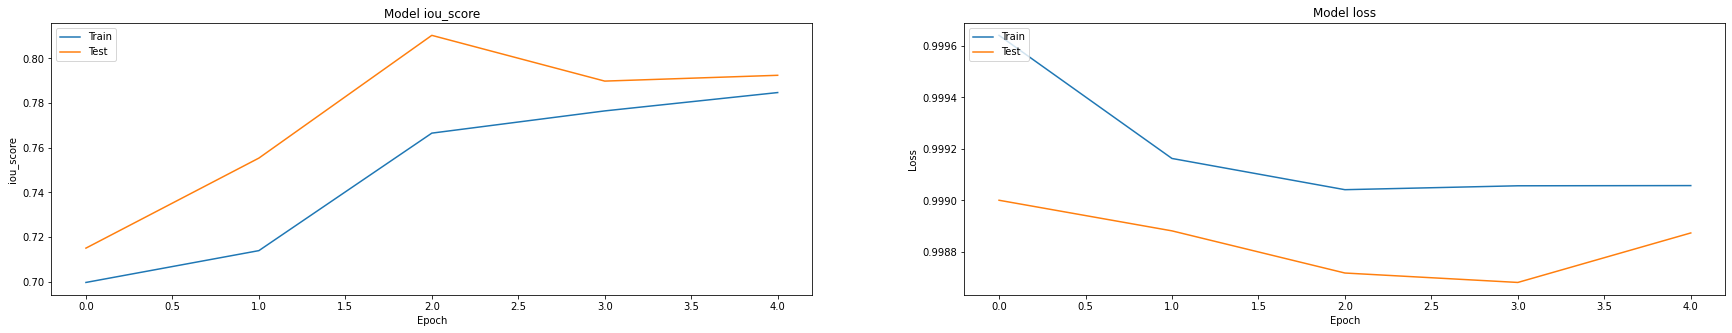

In [38]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

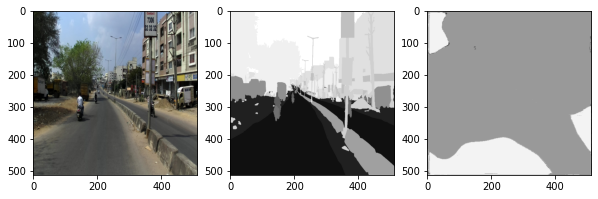

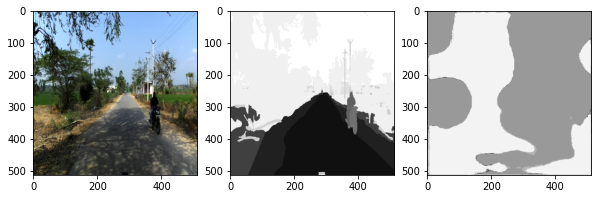

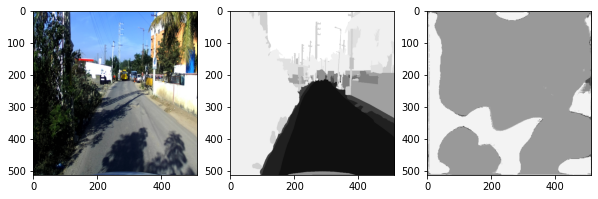

In [52]:
for idx, row in enumerate(X_test[:3].values):
    #original image
    image = cv2.imread(row[0], cv2.IMREAD_UNCHANGED) 
    image = cv2.resize(image, (512,512), interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    #predicted segmentation map
    predicted_mask  = model.predict(image[np.newaxis,:,:,:])
    predicted_mask = tf.argmax(predicted_mask, axis=-1)

    #original segmentation map
    image_mask = cv2.imread(row[2], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray')
    plt.subplot(133)
    plt.imshow(predicted_mask[0], cmap='gray')
    plt.show()

# Task 3: Training CANet

In [31]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* We will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf



In [32]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride

        self.conv_1 = Conv2D(self.F1,(1,1),strides=(self.stride,self.stride),padding='same', activation='relu')
        self.conv_2 = Conv2D(self.F2,(self.kernel,self.kernel),strides=(1,1),padding='same', activation='relu')
        self.conv_3 = Conv2D(self.F3,(1,1),strides=(1,1),padding='same', activation='relu')
        self.conv_4 = Conv2D(self.F3,(self.kernel,self.kernel),strides=(self.stride,self.stride),padding='same', activation='relu')
        
        self.bn1 = BatchNormalization(axis=3)
        self.bn2 = BatchNormalization(axis=3)
        self.bn3 = BatchNormalization(axis=3)
        self.bn4 = BatchNormalization(axis=3)
        
        self.activation = Activation("relu")
        
        self.add = Add()

    def call(self, X):
        # write the architecutre that was mentioned above

        X_input = X
        conv1 = self.conv_1(X)
        bn1 = self.bn1(conv1)
        act1 = self.activation(bn1)

        conv2 = self.conv_2(act1)
        bn2 = self.bn2(conv2)
        act2 = self.activation(bn2)

        conv3 = self.conv_3(act2)
        bn3 = self.bn3(conv3)

        conv4 = self.conv_4(X_input)
        bn4 = self.bn4(conv4)
        act3 = self.activation(bn4)

        X_final = self.add([bn3, act3])
        X_final = self.activation(X_final)


        return X_final

In [33]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel

        self.conv_1 = Conv2D(self.F1, (1,1), strides=(1,1), padding="same", activation="relu")
        self.conv_2 = Conv2D(self.F2, (self.kernel,self.kernel), strides=(1,1), padding="same", activation="relu")
        self.conv_3 = Conv2D(self.F3, (1,1), strides=(1,1), padding="same", activation="relu")
        
        self.bn1 = BatchNormalization(axis=3)
        self.bn2 = BatchNormalization(axis=3)
        self.bn3 = BatchNormalization(axis=3)
        
        self.activation = Activation("relu")
        
        self.add = Add()

    def call(self, X):
        # write the architecutre that was mentioned above

        X_input = X       
        conv1 = self.conv_1(X)
        bn1 = self.bn1(conv1)
        act1 = self.activation(bn1)
        
        conv2 = self.conv_2(act1)
        bn2 = self.bn2(conv2)
        act2 = self.activation(bn2)
        
        conv3 = self.conv_3(act2)
        bn3 = self.bn3(conv3)
        
        X_final = self.add([X_input, bn3])
        X_final = self.activation(X_final)

        return X_final

In [34]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        
        self.conv1 = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same', activation='relu')
        self.global_avg_pool = GlobalAveragePooling2D()
        self.reshape = Reshape(target_shape=(1,1,64))
        self.bn = BatchNormalization(axis=3)
        self.activation = Activation("relu")
        self.upsample = UpSampling2D(size=(16,16),interpolation='bilinear')
        
    def call(self, X):
        # implement the global flow operatiom

        X_input = X
        global_avg_pool = self.global_avg_pool(X_input)
        reshape = self.reshape(global_avg_pool)
        bn1 = self.bn(reshape)
        act1 = self.activation(bn1)
        conv1 = self.conv1(act1)
        X_final = self.upsample(conv1)

        return X_final

In [35]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)

        # self.concat = concatenate()
        self.avg_pool = AveragePooling2D(pool_size=(2, 2))
        self.conv1 = Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same', activation='relu')
        self.conv2 = Conv2D(64,kernel_size=(3,3),strides=(1,1),padding='same', activation='relu')
        self.conv3 = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same', activation='relu')
        self.conv4 = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same', activation='relu')
        self.act1 = Activation("relu")
        self.act2 = Activation("sigmoid")
        self.add = Add()
        self.multiply = Multiply()
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')


    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell

        concat1 = concatenate([INP, FLOW], axis=-1)
        avg_pool = self.avg_pool(concat1)
        conv1 = self.conv1(avg_pool)
        conv2 = self.conv2(conv1)

        conv3 = self.conv3(conv2)
        act1 = self.act1(conv3)
        conv4 = self.conv4(act1)
        act2 = self.act2(conv4)

        mult1 = self.multiply([conv2, act2])
        add1 = self.add([mult1, conv2])
        X_final = self.upsample(add1)

        return X_final

In [36]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)

        self.conv1 = Conv2D(32,kernel_size=(3,3),strides=(1,1),padding='same', activation='relu')
        self.conv2 = Conv2D(32,kernel_size=(1,1),strides=(1,1),padding='same', activation='relu')
        self.global_pool = GlobalMaxPooling2D()
        self.reshape = Reshape(target_shape=(1,1,32))
        self.bn1 = BatchNormalization(axis=3)
        self.act = Activation("sigmoid")
        self.multiply = Multiply()
        self.upsample = UpSampling2D(size=(8,8),interpolation='bilinear')
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells

        X_input = X
        conv1 = self.conv1(X_input)

        global_pool = self.global_pool(conv1)
        reshape = self.reshape(global_pool)
        conv2 = self.conv2(reshape)
        bn1 = self.bn1(conv2)
        act = self.act(bn1)

        mult1 = self.multiply([conv1, act])
        FSM_Conv_T = self.upsample(mult1)

        return FSM_Conv_T

In [37]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)

        self.conv1 = Conv2D(32,kernel_size=(7,1),strides=(1,1),padding='same', activation='relu')
        self.conv2 = Conv2D(32,kernel_size=(1,7),strides=(1,1),padding='same', activation='relu')
        self.conv3 = Conv2D(32,kernel_size=(1,7),strides=(1,1),padding='same', activation='relu')
        self.conv4 = Conv2D(32,kernel_size=(7,1),strides=(1,1),padding='same', activation='relu')
        self.conv5 = Conv2D(32,kernel_size=(3,3),strides=(1,1),padding='same', activation='relu')

        self.add = Add() 
        
    def call(self, X):
        # please implement the above mentioned architecture

        X_input = X

        conv1 = self.conv1(X_input)
        conv2 = self.conv2(conv1)

        conv3 = self.conv3(X_input)
        conv4 = self.conv4(conv3)

        add1 = self.add([conv2, conv4])
        conv5 = self.conv5(add1)
        X_final = self.add([add1, conv5])

        return X_final

In [38]:
tf.keras.backend.clear_session()

X_input = Input(shape=(512,512,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)

# C1
c1_conv_block = convolutional_block(kernel=3, filters=[4,4,8], stride=2, name='c1_conv_block')(X)
print(f"Shape of c1_conv_block is: {c1_conv_block.shape}")
c1_id_block_1 = identity_block(kernel=3, filters=[4,4,8], name='c1_id_block_1')(c1_conv_block)
print(f"Shape of c1_id_block_1 is: {c1_id_block_1.shape}")

#C2
c2_conv_block = convolutional_block(kernel=3, filters=[8,8,16], stride=2, name='c2_conv_block')(c1_id_block_1)
print(f"Shape of c2_conv_block is: {c2_conv_block.shape}")
c2_id_block_1 = identity_block(kernel=3, filters=[8,8,16], name='c2_id_block_1')(c2_conv_block)
print(f"Shape of c2_id_block_1 is: {c2_id_block_1.shape}")
c2_id_block_2 = identity_block(kernel=3, filters=[8,8,16], name='c2_id_block_2')(c2_id_block_1)
print(f"Shape of c2_id_block_2 is: {c2_id_block_2.shape}")

#C3
c3_conv_block = convolutional_block(kernel=3, filters=[16,16,32], stride=2, name='c3_conv_block')(c2_id_block_2)
print(f"Shape of c3_conv_block is: {c3_conv_block.shape}")
c3_id_block_1 = identity_block(kernel=3, filters=[16,16,32], name='c3_id_block_1')(c3_conv_block)
print(f"Shape of c3_id_block_1 is: {c3_id_block_1.shape}")
c3_id_block_2 = identity_block(kernel=3, filters=[16,16,32], name='c3_id_block_2')(c3_id_block_1)
print(f"Shape of c3_id_block_2 is: {c3_id_block_2.shape}")
c3_id_block_3 = identity_block(kernel=3, filters=[16,16,32], name='c3_id_block_3')(c3_id_block_2)
print(f"Shape of c3_id_block_3 is: {c3_id_block_3.shape}")

#C4
c4_conv_block = convolutional_block(kernel=3, filters=[32,32,64], stride=2, name='c4_conv_block')(c3_id_block_3)
print(f"Shape of c4_conv_block is: {c4_conv_block.shape}")
c4_id_block_1 = identity_block(kernel=3, filters=[32,32,64], name='c4_id_block_1')(c4_conv_block)
print(f"Shape of c4_id_block_1 is: {c4_id_block_1.shape}")
c4_id_block_2 = identity_block(kernel=3, filters=[32,32,64], name='c4_id_block_2')(c4_id_block_1)
print(f"Shape of c4_id_block_2 is: {c4_id_block_2.shape}")
c4_id_block_3 = identity_block(kernel=3, filters=[32,32,64], name='c4_id_block_3')(c4_id_block_2)
print(f"Shape of c4_id_block_3 is: {c4_id_block_3.shape}")
c4_id_block_4 = identity_block(kernel=3, filters=[32,32,64], name='c4_id_block_4')(c4_id_block_3)
print(f"Shape of c4_id_block_4 is: {c4_id_block_4.shape}")


#global flow
gf = global_flow()(c4_id_block_4)
print(f"Shape of global flow is: {gf.shape}")

#context flow 1
cf1 = context_flow(name='context_flow_1')([c4_id_block_4, gf])
print(f"Shape of context flow 1 is: {cf1.shape}")

#context flow 2
cf2 = context_flow(name='context_flow_2')([c4_id_block_4, cf1])
print(f"Shape of context flow 2 is: {cf2.shape}")

#context flow 3
cf3 = context_flow(name='context_flow_3')([c4_id_block_4, cf2])
print(f"Shape of context flow 3 is: {cf3.shape}")

#FSM Module
add1 = Add()([gf,cf1,cf2,cf3])
fsm = fsm()(add1)
print(f"Shape of FSM Module is: {fsm.shape}")

#AGCN
agcn = agcn()(c1_conv_block)
print(f"Shape of AGCN is: {agcn.shape}")

#Concatenate FSM and AGCN
concat = concatenate([agcn,fsm])
print(f"Shape of Concat (FSM+AGCN) is: {concat.shape}")

final_conv = Conv2D(21, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu")(concat)
print(f"Shape of final_conv is: {final_conv.shape}")

final_upsample = UpSampling2D(size=(4,4),interpolation='bilinear')(final_conv)
print(f"Shape of final_upsample is: {final_upsample.shape}")

final_act = Activation("softmax")(final_upsample)
print(f"Shape of softmax activation is: {final_act.shape}")

(None, 256, 256, 64)
Shape of c1_conv_block is: (None, 128, 128, 8)
Shape of c1_id_block_1 is: (None, 128, 128, 8)
Shape of c2_conv_block is: (None, 64, 64, 16)
Shape of c2_id_block_1 is: (None, 64, 64, 16)
Shape of c2_id_block_2 is: (None, 64, 64, 16)
Shape of c3_conv_block is: (None, 32, 32, 32)
Shape of c3_id_block_1 is: (None, 32, 32, 32)
Shape of c3_id_block_2 is: (None, 32, 32, 32)
Shape of c3_id_block_3 is: (None, 32, 32, 32)
Shape of c4_conv_block is: (None, 16, 16, 64)
Shape of c4_id_block_1 is: (None, 16, 16, 64)
Shape of c4_id_block_2 is: (None, 16, 16, 64)
Shape of c4_id_block_3 is: (None, 16, 16, 64)
Shape of c4_id_block_4 is: (None, 16, 16, 64)
Shape of global flow is: (None, 16, 16, 64)
Shape of context flow 1 is: (None, 16, 16, 64)
Shape of context flow 2 is: (None, 16, 16, 64)
Shape of context flow 3 is: (None, 16, 16, 64)
Shape of FSM Module is: (None, 128, 128, 32)
Shape of AGCN is: (None, 128, 128, 32)
Shape of Concat (FSM+AGCN) is: (None, 128, 128, 64)
Shape of fin

In [39]:
# write the complete architecutre

model_2 = Model(inputs = X_input, outputs = final_act)
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           bn_conv1[0][0]                   
______________________________________________________________________________________________

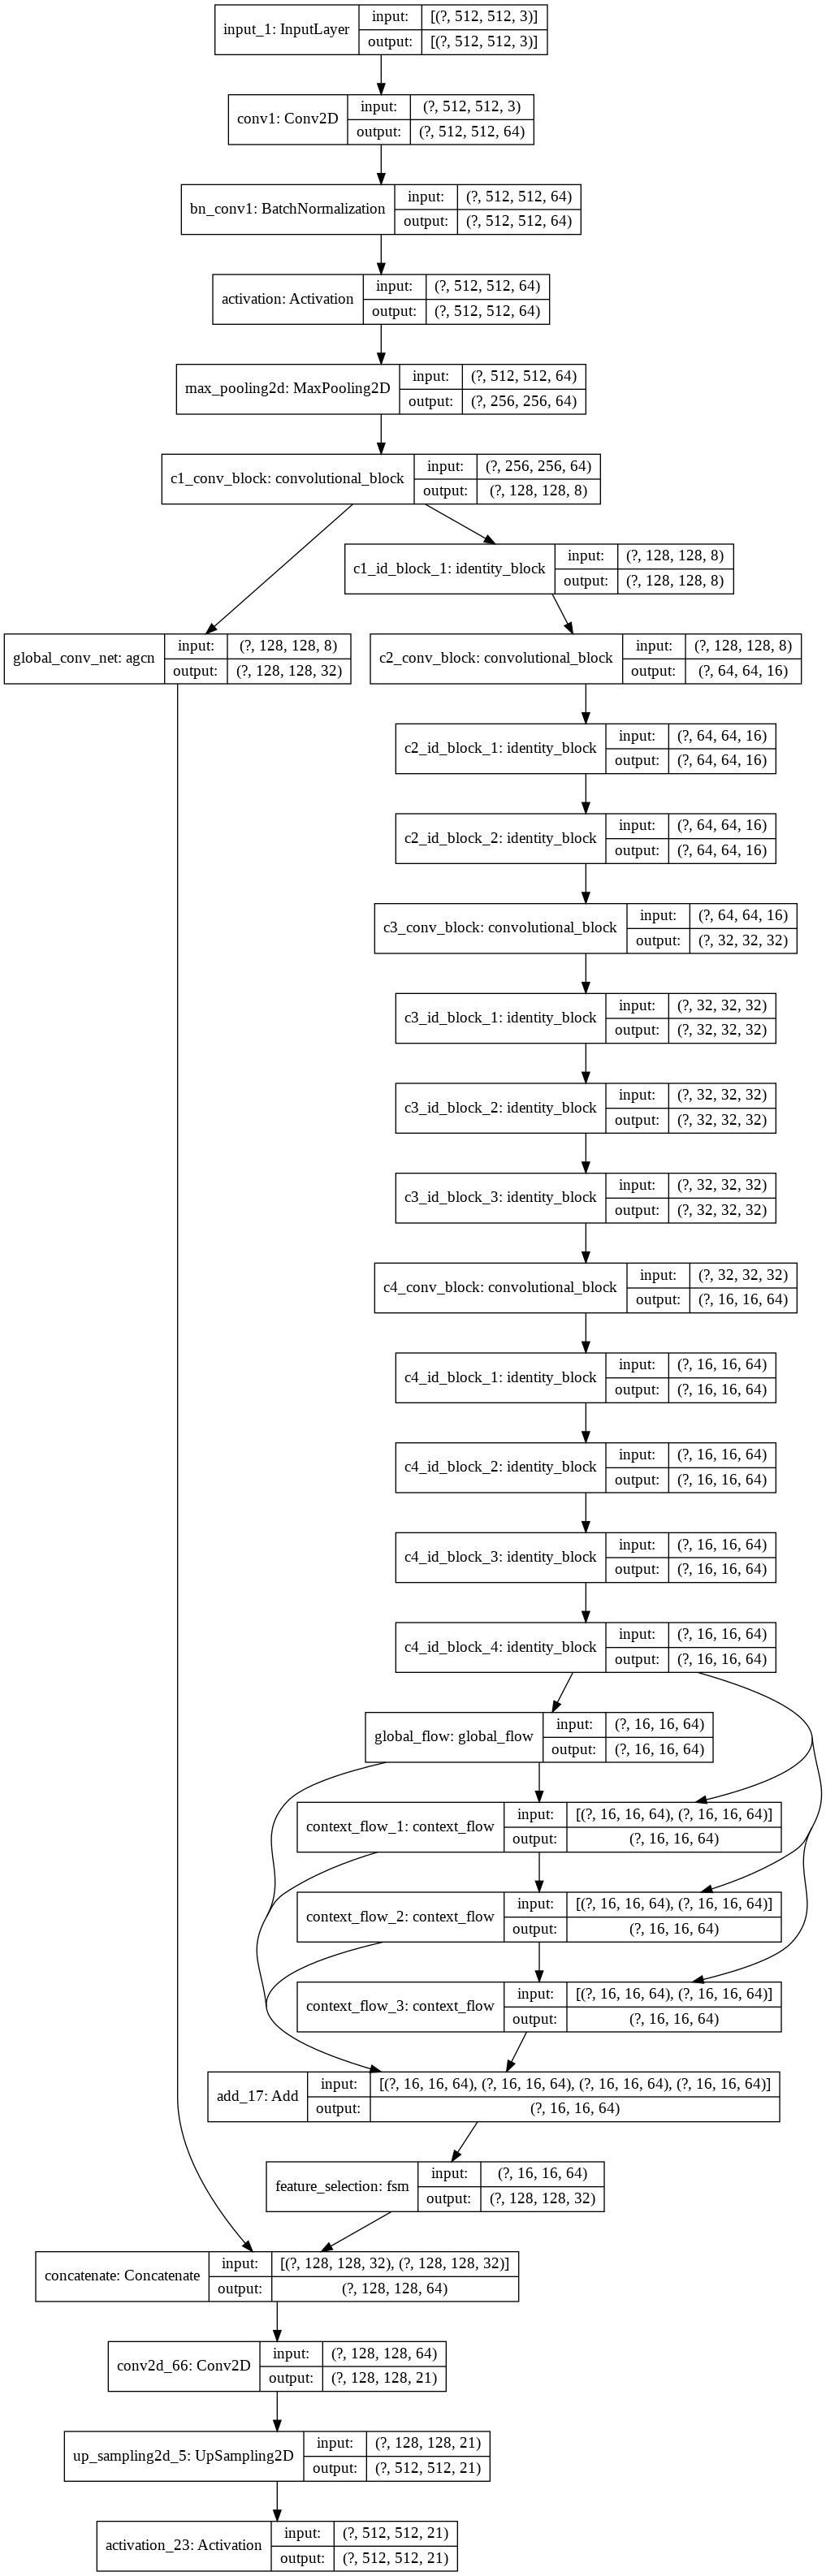

In [40]:
tf.keras.utils.plot_model(
    model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [40]:
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.0001,clipvalue = 0.5)

# iou_score= sm.metrics.IOUScore(threshold=0.5)

focal_loss = sm.losses.cce_dice_loss

model_2.compile(optim, focal_loss, metrics=[sm.metrics.IOUScore(threshold=0.5)])

In [41]:
# Dataset for train images
CLASSES = list(range(21))

train_dataset = Dataset(X_train, classes=CLASSES)
test_dataset  = Dataset(X_test, classes=CLASSES)


train_dataloader = Dataloader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

# define callbacks for learning rate scheduling and best checkpoints saving

 
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model_2.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)
]

(1, 512, 512, 3)
(1, 512, 512, 21)


In [42]:
history_2 = model_2.fit_generator(train_dataloader, steps_per_epoch=train_dataloader.__len__(), epochs=5,\
                              validation_data=test_dataloader,validation_steps=test_dataloader.__len__(),callbacks=callbacks, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
3206/3206 [==============================] - 524s 164ms/step - loss: 0.4062 - iou_score: 0.9457 - val_loss: 1.0000 - val_iou_score: 0.9662 - lr: 1.0000e-04
Epoch 2/5
3206/3206 [==============================] - 533s 166ms/step - loss: 0.0476 - iou_score: 0.9524 - val_loss: 1.0000 - val_iou_score: 0.9662 - lr: 1.0000e-04
Epoch 3/5
3206/3206 [==============================] - 527s 164ms/step - loss: 0.0476 - iou_score: 0.9524 - val_loss: 1.0000 - val_iou_score: 0.9662 - lr: 1.0000e-04
Epoch 4/5
3206/3206 [==============================] - 527s 164ms/step - loss: 0.0476 - iou_score: 0.9524 - val_loss: 1.0000 - val_iou_score: 0.9662 - lr: 1.0000e-05
Epoch 5/5
3206/3206 [==============================] - 534s 167ms/step - loss: 0.0476 - iou_score: 0.9524 - val_loss: 1.0000 - val_iou_score: 0.9662 - lr: 1.0000e-05


In [ ]:
model.save("model_2.h5")

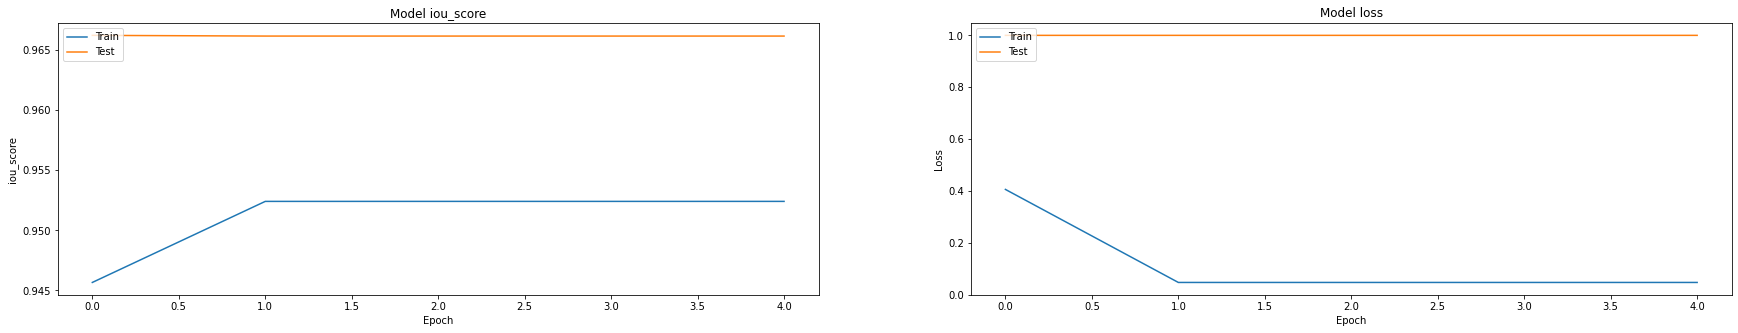

In [43]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_2.history['iou_score'])
plt.plot(history_2.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

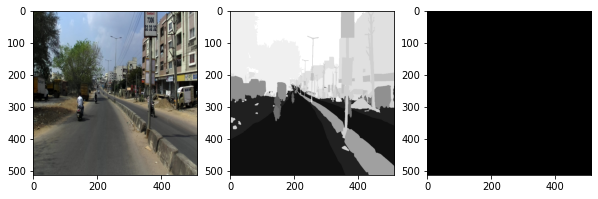

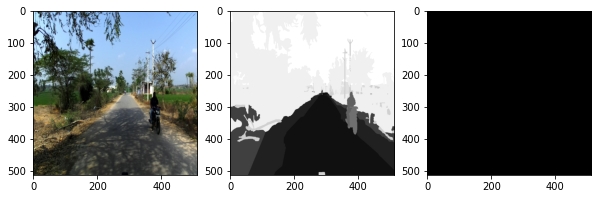

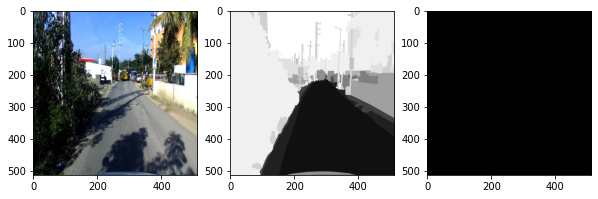

In [44]:
for idx, row in enumerate(X_test[:3].values):
    #original image
    image = cv2.imread(row[0], cv2.IMREAD_UNCHANGED) 
    image = cv2.resize(image, (512,512), interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    #predicted segmentation map
    predicted_mask  = model_2.predict(image[np.newaxis,:,:,:])
    predicted_mask = tf.argmax(predicted_mask, axis=-1)

    #original segmentation map
    image_mask = cv2.imread(row[2], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (512,512))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask, cmap='gray')
    plt.subplot(133)
    plt.imshow(predicted_mask[0], cmap='gray')
    plt.show()